<a href="https://colab.research.google.com/github/temurera/Deep-Learning/blob/master/VariationalAutoencoder_g.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

In this section Variational Autoencoder architecture was implemented using widely used MNIST dataset

## Mount Google drive 

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Thu Dec  5 18:41:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Loading Environment

In [0]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the MNIST data

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=32, shuffle=True)

# Implemented the VAE Architecture

Designed a Variational Autoencoder Architecture using ConvTranspose2d and Activation Layers

In [0]:
class VAE(torch.nn.Module):
    """
    Implement Variational Autoencoder
    """
    def __init__(self):
        """
        Implement architecture
        """
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2,padding=1), #64*14*14
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2,padding=1), #128*7*7
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(6272, 2)
        self.fc2 = nn.Linear(6272, 2)
        self.fc3 = nn.Linear(2, 128*7*7)
        

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
            
        )
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar
    def decode(self,x):
        x = self.fc3(x)
        x = x.view(x.size(0), 128, 7, 7)
        x = self.decoder(x)
        return x



    def forward(self, x):
        """
        Implement forward-pass
        """
        x, mu, logvar = self.encode(x)
        x = self.decode(x)

        return x, mu, logvar

In [0]:
vae = VAE()

## Initialization of the Optimizer

In [0]:
optimizer = optim.Adam(vae.parameters(), lr=0.0002)

## Variational Autoencoder combines Reconstruction Loss and KL Divergence Loss

In [0]:
#loss = None

def loss_func(x_sample, x, mu, log_var):
    recon_loss = F.binary_cross_entropy(x_sample.view(-1, 784), x.view(-1, 784), reduction='sum')

    # kl divergence loss
    kl_loss = 0.5 * torch.sum(torch.exp(log_var) + mu**2 - 1.0 - log_var)

    loss = recon_loss + kl_loss
    return loss

## Training loop

In [0]:
num_epochs = 20
vae.train()
train_loss_avg = []
for epoch in range(num_epochs):
    for n_batch, (batch,_) in enumerate(train_loader):
        train_loss_avg.append(0)
        #batch = batch.to(device)
        rcn_image, mu, log_var = vae(batch)
        loss = loss_func(rcn_image, batch, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        error = loss
        train_loss_avg[-1] += loss.item()
        
        train_loss_avg[-1] /= (n_batch+1)
        #pass
        
        if (n_batch + 1) % 100 == 0:
            print("epoch: {%d}, batch number: {%d}, error: {%.4f}" % 
                  #(epoch + 1, n_batch + 1, error.item(), ))
                  (epoch + 1, n_batch + 1, train_loss_avg[-1], ))
            

epoch: {1}, batch number: {100}, error: {71.4374}
epoch: {1}, batch number: {200}, error: {30.9350}
epoch: {1}, batch number: {300}, error: {20.3967}
epoch: {1}, batch number: {400}, error: {13.5044}
epoch: {1}, batch number: {500}, error: {11.2688}
epoch: {1}, batch number: {600}, error: {9.8250}
epoch: {1}, batch number: {700}, error: {8.2981}
epoch: {1}, batch number: {800}, error: {7.4105}
epoch: {1}, batch number: {900}, error: {6.2020}
epoch: {1}, batch number: {1000}, error: {5.7294}
epoch: {1}, batch number: {1100}, error: {5.0845}
epoch: {1}, batch number: {1200}, error: {4.9060}
epoch: {1}, batch number: {1300}, error: {4.3610}
epoch: {1}, batch number: {1400}, error: {4.0936}
epoch: {1}, batch number: {1500}, error: {3.6015}
epoch: {1}, batch number: {1600}, error: {3.2420}
epoch: {1}, batch number: {1700}, error: {2.8573}
epoch: {1}, batch number: {1800}, error: {3.2370}
epoch: {2}, batch number: {100}, error: {49.7914}
epoch: {2}, batch number: {200}, error: {27.3751}
epoc

## Randomly generated a sample then traversed in its latent space dimensions (adding small numbers to only two dimension)

Original images


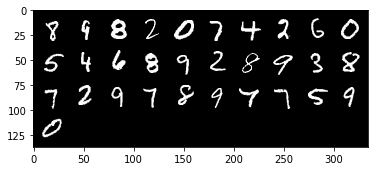

VAE reconstruction:


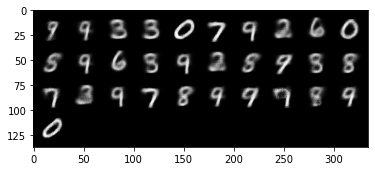

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        #images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_loader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

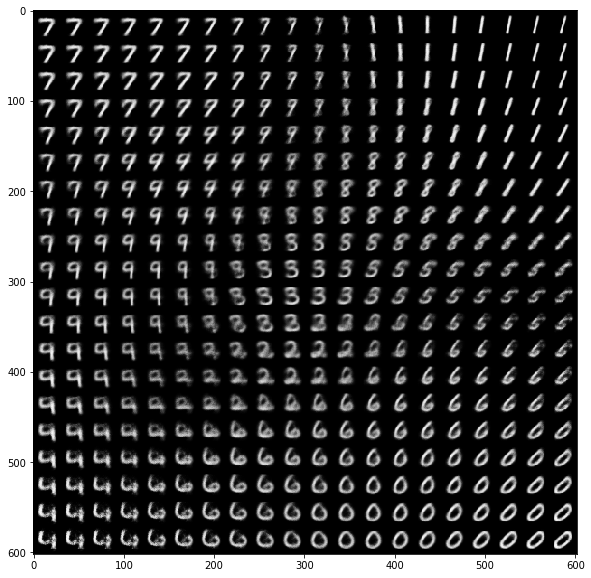

In [0]:
vae.eval()
latent_dims = 2
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(2,-2,20)
    latent_y = np.linspace(2,-2,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    #latents = latents.to(device)
    image_recon = vae.decode(latents)
    #image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,2))
    plt.show()